# Decision Trees

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

## Importing Data and Pre-processing

In [2]:
# Import Data
data = pd.read_csv('data.txt',index_col=0)
pd.set_option('display.max_columns', 12)
data.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5,Contains_Crack,Position_of_Crack
0,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
1,161.168,1.043284,1.038036,0.094323,1.031535,1.092445,...,0.069334,0.086817,0.460091,0.254838,Yes,Top Right
2,164.121,1.146271,1.026070,0.055705,1.013540,1.031031,...,0.391759,0.011229,0.163528,0.319310,Yes,Top Left
3,162.045,1.042523,1.045912,0.044661,1.056414,1.046251,...,0.053956,0.022008,0.054064,0.054362,Yes,Bottom Left
4,163.042,1.040145,1.030799,0.015596,1.043248,1.064751,...,0.053708,0.016016,0.057733,0.101230,Yes,Bottom Right
5,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
6,159.572,1.047045,1.027146,0.083370,1.042486,1.054308,...,0.146392,0.110386,0.068477,0.118288,Yes,Top Right


In [3]:
# Adding Noise
np.random.seed(1)
for col in data:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data.loc[data['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data.loc[data['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data[col]))
        data[col] = data[col] + noise
data.shape

(100, 56)

In [4]:
# Remove the target from the dataset
data.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1 = data.Contains_Crack
y2 = data.Position_of_Crack
data.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
data

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,...,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,...,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,...,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,...,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,...,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,162.965998,1.056900,1.019373,0.023410,1.061058,0.888231,...,843.224625,-0.005461,-0.050806,0.051564,0.064393,-0.022629
96,160.879274,1.022117,1.119511,0.082316,1.057186,0.832265,...,827.146286,0.127383,0.116638,0.248995,0.304281,0.077025
97,162.440264,1.028118,1.011183,0.019398,1.055071,0.977400,...,828.464281,0.000394,0.245330,0.056035,0.243257,0.208921
98,163.178099,1.018555,1.058280,0.050581,1.157652,0.794373,...,835.827020,0.500143,0.284131,0.042238,0.096635,0.045737


In [5]:
# Encoding targets
for idx in range(len(y1)):
    if y1[idx] == 'Yes':
        y1[idx] = int(1)
    elif y1[idx] == 'No': 
        y1[idx] = int(0)
    
    if y2[idx] == 'No Crack':
        y2[idx] = int(0)
    elif y2[idx] == 'Top Right':
        y2[idx] = int(1)
    elif y2[idx] == 'Top Left':
        y2[idx] = int(2)
    elif y2[idx] == 'Bottom Left':
        y2[idx] = int(3)
    elif y2[idx] == 'Bottom Right':
        y2[idx] = int(4)
y1.to_numpy(dtype=int)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [6]:
# Split the data into feature sets
X1 = data
X2 = data[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3 = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

In [7]:
# Splitting into testing and training for the different feature sets
X_train11, X_test11, y_train11, y_test11 = train_test_split(X1, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train21, X_test21, y_train21, y_test21 = train_test_split(X2, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train31, X_test31, y_train31, y_test31 = train_test_split(X3, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X1, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train22, X_test22, y_train22, y_test22 = train_test_split(X2, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train32, X_test32, y_train32, y_test32 = train_test_split(X3, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)

In [8]:
# Mean Center the data
for col in X_train11:
    X_test11.loc[:,col] = X_test11.loc[:,col] - X_train11.loc[:,col].mean()
    X_train11.loc[:,col] = X_train11.loc[:,col] - X_train11.loc[:,col].mean()
    
    X_test12.loc[:,col] = X_test12.loc[:,col] - X_train12.loc[:,col].mean()
    X_train12.loc[:,col] = X_train12.loc[:,col] - X_train12.loc[:,col].mean()

for col in X_train21:
    X_test21.loc[:,col] = X_test21.loc[:,col] - X_train21.loc[:,col].mean()
    X_train21.loc[:,col] = X_train21.loc[:,col] - X_train21.loc[:,col].mean()
    
    X_test22.loc[:,col] = X_test22.loc[:,col] - X_train22.loc[:,col].mean()
    X_train22.loc[:,col] = X_train22.loc[:,col] - X_train22.loc[:,col].mean()
    
for col in X_train31:
    X_test31.loc[:,col] = X_test31.loc[:,col] - X_train31.loc[:,col].mean()
    X_train31.loc[:,col] = X_train31[col] - X_train31[col].mean()
    
    X_test32.loc[:,col] = X_test32.loc[:,col] - X_train32.loc[:,col].mean()
    X_train32.loc[:,col] = X_train32.loc[:,col] - X_train32.loc[:,col].mean()

X_train11

C:\Users\James\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
43,3.581602,-0.048451,-0.043658,0.052843,0.100453,-0.158342,...,-0.181764,0.356719,0.337481,0.177689,-0.074283,0.050663
62,1.604523,0.025551,0.007492,0.004462,-0.022159,0.030694,...,-1.271669,-0.142383,-0.115478,0.050465,0.031750,0.175242
3,-0.952166,-0.004978,0.001227,0.013602,0.016607,-0.294224,...,4.279401,-0.045163,0.043198,-0.098740,-0.060349,-0.100357
71,-0.730195,0.010480,-0.007981,-0.061000,-0.010028,0.055629,...,-0.387632,-0.141004,-0.026556,0.075769,0.035946,0.057299
45,1.217865,-0.011695,-0.002813,-0.025489,0.011686,-0.381480,...,5.493934,-0.156968,-0.144323,-0.128259,-0.087670,-0.010572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-1.513553,-0.020967,0.066908,0.046525,0.008887,-0.340432,...,-7.000913,-0.038615,-0.014008,0.174715,0.160426,-0.060633
67,-3.011306,-0.006248,-0.003369,0.057404,-0.000890,0.087405,...,7.184263,0.033165,-0.159252,0.001808,-0.146549,-0.198326
64,-0.468779,-0.010707,0.005931,0.009249,0.010759,0.015932,...,-0.832896,0.133012,0.014252,0.299752,-0.118206,0.112470
47,-0.152822,0.002789,-0.014487,-0.026338,0.009009,-0.223336,...,4.725110,-0.170896,-0.006564,-0.107392,0.075193,-0.076399


## No Scaling

Predicted values using x1 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



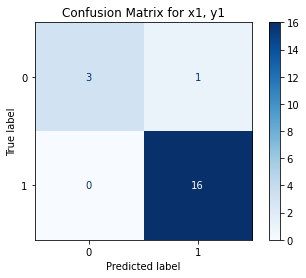

Predicted values using x2 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



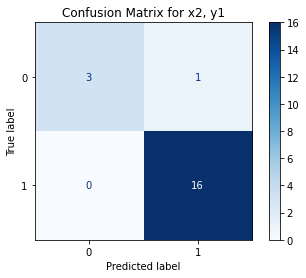

Predicted values using x3 and y1: [1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.85 and f1 score of: 0.9090909090909091 and AUC score of 0.71875 



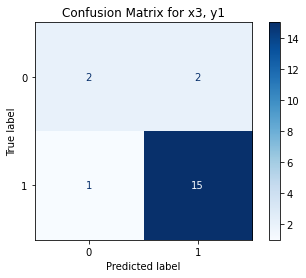

In [9]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X_train11, y_train11)

x1y1_predict = x1y1_tree.predict(X_test11)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X_test11,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X_train21, y_train21)

x2y1_predict = x2y1_tree.predict(X_test21)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X_test21,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X_train31, y_train31)

x3y1_predict = x3y1_tree.predict(X_test31)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X_test31,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 2 1 3 3 0 2 2 2 2 2 0 2 1 1 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.6 and f1 score of: 0.5277777777777778 and AUC score of 0.7678571428571429 



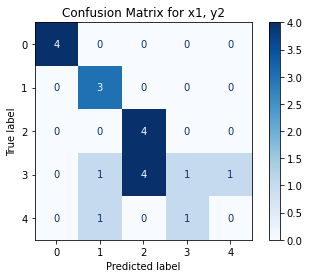

Predicted values using x2 and y2: [2 4 1 4 0 1 1 1 2 0 4 2 1 4 3 0 3 1 1 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.3 and f1 score of: 0.3085714285714286 and AUC score of 0.5595238095238095 



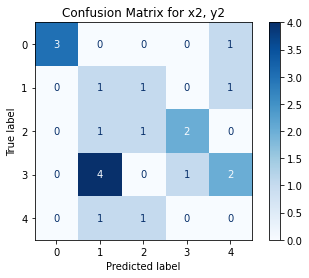

Predicted values using x3 and y2: [1 1 2 0 0 3 2 3 2 0 1 2 3 2 3 3 2 0 0 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.6 and f1 score of: 0.5097435897435897 and AUC score of 0.7172619047619048 



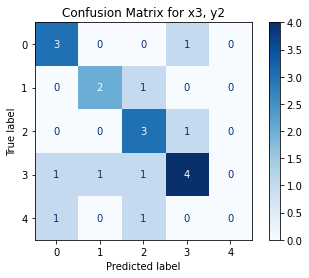

In [11]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X_train12, y_train12)

x1y2_predict = x1y2_tree.predict(X_test12)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X_test12)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X_test12,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X_train22, y_train22)

x2y2_predict = x2y2_tree.predict(X_test22)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X_test22)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X_test22,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X_train32, y_train32)

x3y2_predict = x3y2_tree.predict(X_test32)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X_test32)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X_test32,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## Normalisation

In [23]:
# Normalize the data
normalizer = Normalizer('l2')
X_train11_norm = pd.DataFrame(normalizer.fit_transform(X_train11))
X_test11_norm = pd.DataFrame(normalizer.transform(X_test11))
  
normalizer = Normalizer('l2')
X_train12_norm = pd.DataFrame(normalizer.fit_transform(X_train12))
X_test12_norm = pd.DataFrame(normalizer.transform(X_test12))

normalizer = Normalizer('l2')
X_train21_norm = pd.DataFrame(normalizer.fit_transform(X_train21))
X_test21_norm = pd.DataFrame(normalizer.transform(X_test21))

normalizer = Normalizer('l2')
X_train22_norm = pd.DataFrame(normalizer.fit_transform(X_train22))
X_test22_norm = pd.DataFrame(normalizer.transform(X_test22))

normalizer = Normalizer('l2')
X_train31_norm = pd.DataFrame(normalizer.fit_transform(X_train31))
X_test31_norm = pd.DataFrame(normalizer.transform(X_test31))

normalizer = Normalizer('l2')
X_train32_norm = pd.DataFrame(normalizer.fit_transform(X_train32))
X_test32_norm = pd.DataFrame(normalizer.transform(X_test32))

X_train32_norm

,0,1,2,3,4
0,0.397813,-0.238586,-0.095298,0.771969,0.424032
1,0.513168,-0.005580,-0.062190,-0.272431,-0.811506
2,-0.361775,-0.090618,0.079766,-0.494664,-0.780930
3,0.582187,0.047607,-0.104903,0.084496,-0.800404
4,-0.603528,0.077316,0.087650,0.217709,-0.758088
...,...,...,...,...,...
75,0.231797,0.803299,0.091714,0.215936,-0.495925
76,0.388689,0.401395,0.165437,0.481770,-0.654471
77,-0.121543,-0.348609,-0.077263,-0.228691,0.897458
78,-0.040054,0.067348,-0.045395,0.686705,0.721273


Predicted values using x1 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.9 and f1 score of: 0.9375 and AUC score of 0.84375 



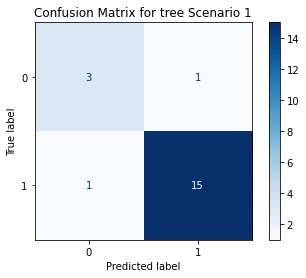

Predicted values using x2 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



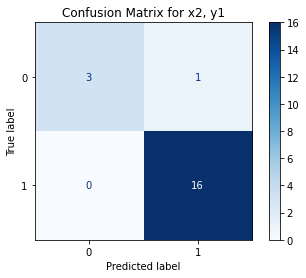

Predicted values using x3 and y1: [1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.875 and AUC score of 0.6875 



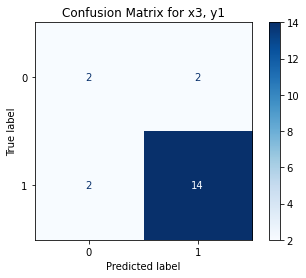

In [24]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X_train11_norm, y_train11)

x1y1_predict = x1y1_tree.predict(X_test11_norm)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X_test11_norm,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for tree Scenario 1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X_train21_norm, y_train21)

x2y1_predict = x2y1_tree.predict(X_test21_norm)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X_test21_norm,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X_train31_norm, y_train31)

x3y1_predict = x3y1_tree.predict(X_test31_norm)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X_test31_norm,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 2 2 0 0 3 2 3 3 0 3 2 3 2 2 0 2 4 4 1]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.7 and f1 score of: 0.6587878787878787 and AUC score of 0.8005952380952381 



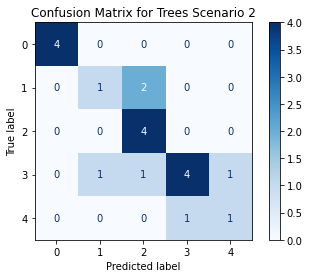

Predicted values using x2 and y2: [4 3 4 0 0 4 1 1 2 0 4 1 3 4 4 0 1 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.337950937950938 and AUC score of 0.6220238095238094 



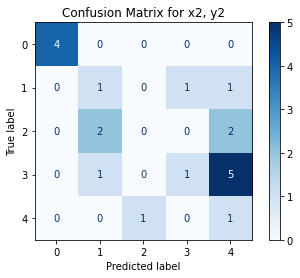

Predicted values using x3 and y2: [1 1 1 0 0 3 1 0 2 2 2 3 3 2 1 1 3 1 3 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.45 and f1 score of: 0.35736263736263735 and AUC score of 0.6339285714285714 



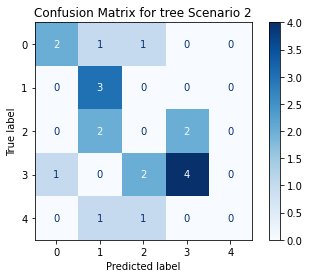

In [25]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X_train12_norm, y_train12)

x1y2_predict = x1y2_tree.predict(X_test12_norm)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X_test12_norm)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X_test12_norm,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Trees Scenario 2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X_train22_norm, y_train22)

x2y2_predict = x2y2_tree.predict(X_test22_norm)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X_test22_norm)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X_test22_norm,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X_train32_norm, y_train32)

x3y2_predict = x3y2_tree.predict(X_test32_norm)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X_test32_norm)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X_test32_norm,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for tree Scenario 2")
plt.show()

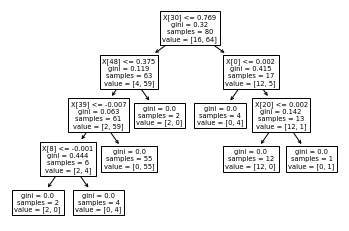

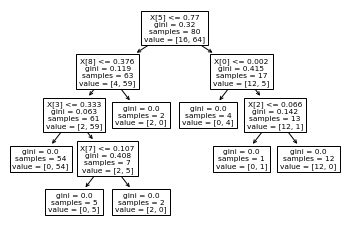

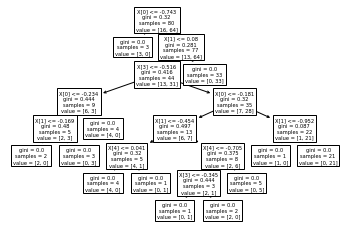

In [26]:
tree.plot_tree(x1y1_tree)
plt.show()
tree.plot_tree(x2y1_tree)
plt.show()
tree.plot_tree(x3y1_tree)
plt.show()

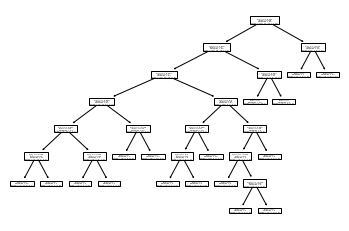

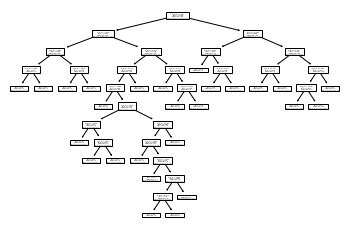

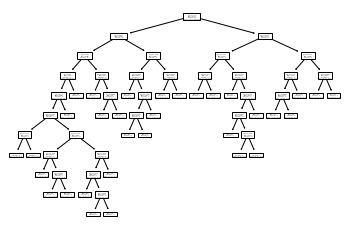

In [27]:
tree.plot_tree(x1y2_tree)
plt.show()
tree.plot_tree(x2y2_tree)
plt.show()
tree.plot_tree(x3y2_tree)
plt.show()

In [28]:
print("x1, y1 number of leaves =",x1y1_tree.get_n_leaves())
print("x2, y1 number of leaves =",x2y1_tree.get_n_leaves())
print("x3, y1 number of leaves =",x3y1_tree.get_n_leaves())
print("Average Leaves =",(x1y1_tree.get_n_leaves()+x2y1_tree.get_n_leaves()+x3y1_tree.get_n_leaves())/3)
print(((x1y1_tree.get_n_leaves()+x2y1_tree.get_n_leaves()+x3y1_tree.get_n_leaves())/3)/2,"leaves per class","\n")

print("x1, y2 number of leaves =",x1y2_tree.get_n_leaves())
print("x2, y2 number of leaves =",x2y2_tree.get_n_leaves())
print("x3, y2 number of leaves =",x3y2_tree.get_n_leaves())
print("Average Leaves =",(x1y2_tree.get_n_leaves()+x2y2_tree.get_n_leaves()+x3y2_tree.get_n_leaves())/3)
print(((x1y2_tree.get_n_leaves()+x2y2_tree.get_n_leaves()+x3y2_tree.get_n_leaves())/3)/5,"leaves per class","\n")

x1, y1 number of leaves = 7
x2, y1 number of leaves = 7
x3, y1 number of leaves = 12
Average Leaves = 8.666666666666666
4.333333333333333 leaves per class 

x1, y2 number of leaves = 17
x2, y2 number of leaves = 26
x3, y2 number of leaves = 32
Average Leaves = 25.0
5.0 leaves per class 



## Z Score Scaling

In [15]:
# Scaling
scaler = StandardScaler()
X_train11_z = scaler.fit_transform(X_train11)
X_test11_z = scaler.transform(X_test11)

scaler = StandardScaler()
X_train21_z = scaler.fit_transform(X_train21)
X_test21_z = scaler.transform(X_test21)

scaler = StandardScaler()
X_train31_z = scaler.fit_transform(X_train31)
X_test31_z = scaler.transform(X_test31)

scaler = StandardScaler()
X_train12_z = scaler.fit_transform(X_train12)
X_test12_z = scaler.transform(X_test12)

scaler = StandardScaler()
X_train22_z = scaler.fit_transform(X_train22)
X_test22_z = scaler.transform(X_test22)

scaler = StandardScaler()
X_train32_z = scaler.fit_transform(X_train32)
X_test32_z = scaler.transform(X_test32)

Predicted values using x1 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



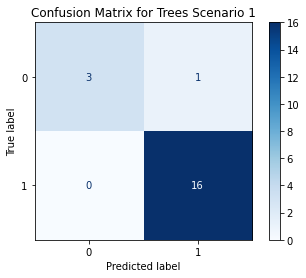

Predicted values using x2 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.9 and f1 score of: 0.9375 and AUC score of 0.84375 



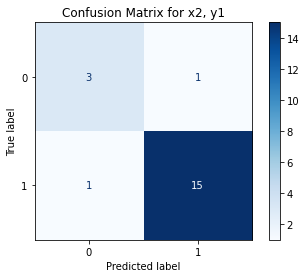

Predicted values using x3 and y1: [1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.85 and f1 score of: 0.9090909090909091 and AUC score of 0.71875 



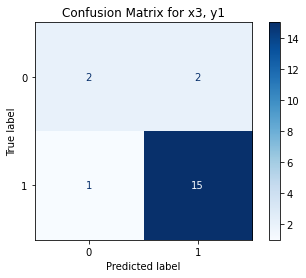

In [21]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X_train11_z, y_train11)

x1y1_predict = x1y1_tree.predict(X_test11_z)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X_test11_z,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Trees Scenario 1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X_train21_z, y_train21)

x2y1_predict = x2y1_tree.predict(X_test21_z)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X_test21_z,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X_train31_z, y_train31)

x3y1_predict = x3y1_tree.predict(X_test31_z)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X_test31_z,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 2 1 3 3 0 2 2 2 2 2 1 2 1 1 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.55 and f1 score of: 0.4825396825396825 and AUC score of 0.7366071428571429 



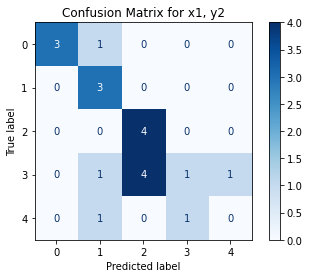

Predicted values using x2 and y2: [2 4 1 4 0 1 1 1 2 0 4 2 1 4 1 0 3 1 1 1]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.25 and f1 score of: 0.2619047619047619 and AUC score of 0.5416666666666666 



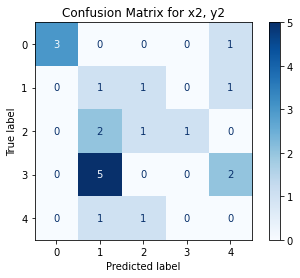

Predicted values using x3 and y2: [1 1 3 3 0 4 1 3 2 0 1 3 2 2 3 2 2 0 0 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.4 and f1 score of: 0.37741147741147746 and AUC score of 0.6294642857142857 



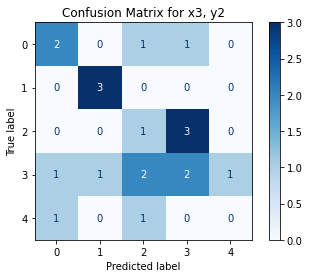

In [17]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X_train12_z, y_train12)

x1y2_predict = x1y2_tree.predict(X_test12_z)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X_test12_z)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X_test12_z,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X_train22_z, y_train22)

x2y2_predict = x2y2_tree.predict(X_test22_z)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X_test22_z)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X_test22_z,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X_train32_z, y_train32)

x3y2_predict = x3y2_tree.predict(X_test32_z)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X_test32_z)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X_test32_z,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

## PCS

In [18]:
# PCA
pca = PCA()
X_train11_PCS = pca.fit_transform(X_train11)
X_test11_PCS = pca.transform(X_test11)

pca = PCA()
X_train21_PCS = pca.fit_transform(X_train21)
X_test21_PCS = pca.transform(X_test21)

pca = PCA()
X_train31_PCS = pca.fit_transform(X_train31)
X_test31_PCS = pca.transform(X_test31)

pca = PCA()
X_train12_PCS = pca.fit_transform(X_train12)
X_test12_PCS = pca.transform(X_test12)

pca = PCA()
X_train22_PCS = pca.fit_transform(X_train22)
X_test22_PCS = pca.transform(X_test22)

pca = PCA()
X_train32_PCS = pca.fit_transform(X_train32)
X_test32_PCS =pca.transform(X_test32)

X_train11_PCS

array([[ 8.37659537e+00, -1.16080732e+01,  7.95487810e+00, ...,
        -1.34124936e-03, -5.65870716e-03, -7.24118352e-03],
       [ 4.87317662e+01, -9.99852623e+00, -5.34152127e+00, ...,
        -7.09420798e-04, -1.15699969e-04,  8.88687730e-03],
       [-1.57985831e+01,  2.50768193e+00,  2.78375561e-02, ...,
         1.16349860e-02,  1.73482187e-02, -6.76086863e-03],
       ...,
       [ 5.52037369e+01, -9.04275557e+00, -4.27233908e+00, ...,
        -3.99463833e-03,  4.18074437e-03, -1.65960319e-03],
       [-2.32143736e+01, -8.27094459e+00, -3.85431951e+00, ...,
        -6.20281396e-03, -1.76908111e-03,  8.01055891e-03],
       [ 9.05585377e+00,  8.16018500e+00,  1.92691506e-01, ...,
         1.01637411e-02, -1.36464649e-02,  4.23947310e-03]])

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.75 and f1 score of: 0.8148148148148148 and AUC score of 0.84375 



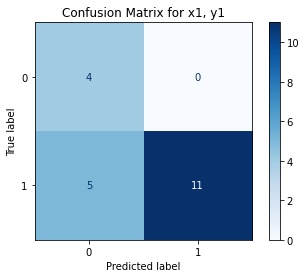

Predicted values using x2 and y1: [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.95 and f1 score of: 0.9696969696969697 and AUC score of 0.875 



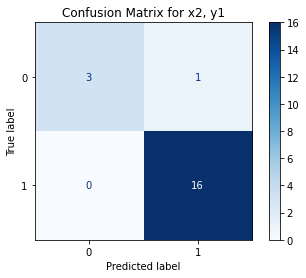

Predicted values using x3 and y1: [1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.85 and f1 score of: 0.9032258064516129 and AUC score of 0.8125 



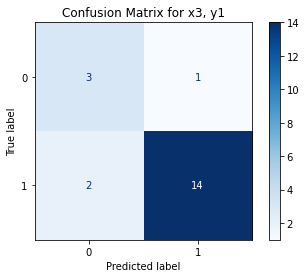

In [19]:
# Situation 1
# x1 y1
x1y1_tree = tree.DecisionTreeClassifier()
x1y1_tree.fit(X_train11_PCS, y_train11)

x1y1_predict = x1y1_tree.predict(X_test11_PCS)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_tree,X_test11_PCS,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1_tree = tree.DecisionTreeClassifier()
x2y1_tree.fit(X_train21_PCS, y_train21)

x2y1_predict = x2y1_tree.predict(X_test21_PCS)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_tree,X_test21_PCS,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1_tree = tree.DecisionTreeClassifier()
x3y1_tree.fit(X_train31_PCS, y_train31)

x3y1_predict = x3y1_tree.predict(X_test31_PCS)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_tree,X_test31_PCS,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [1 1 2 0 0 3 4 2 2 0 4 3 4 2 2 0 2 4 3 0]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.6 and f1 score of: 0.6044444444444446 and AUC score of 0.775297619047619 



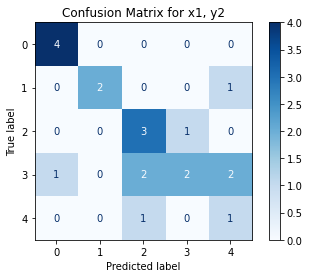

Predicted values using x2 and y2: [1 2 3 2 3 1 4 1 3 0 1 4 3 2 4 0 2 4 4 1]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.3 and f1 score of: 0.3268398268398268 and AUC score of 0.5907738095238095 



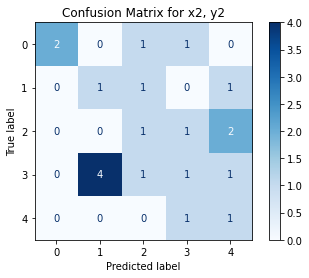

Predicted values using x3 and y2: [1 2 1 2 1 3 1 0 1 0 3 1 3 2 1 2 1 0 0 2]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.3 and f1 score of: 0.24272727272727274 and AUC score of 0.5431547619047619 



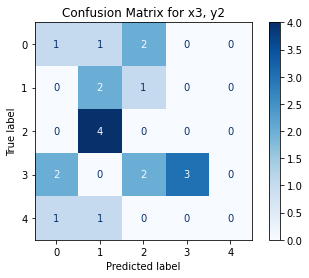

In [20]:
# Situation 2
# x1 y2
x1y2_tree = tree.DecisionTreeClassifier()
x1y2_tree.fit(X_train12_PCS, y_train12)

x1y2_predict = x1y2_tree.predict(X_test12_PCS)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_tree.predict_proba(X_test12_PCS)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_tree,X_test12_PCS,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_tree = tree.DecisionTreeClassifier()
x2y2_tree.fit(X_train22_PCS, y_train22)

x2y2_predict = x2y2_tree.predict(X_test22_PCS)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_tree.predict_proba(X_test22_PCS)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_tree,X_test22_PCS,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_tree = tree.DecisionTreeClassifier()
x3y2_tree.fit(X_train32_PCS, y_train32)

x3y2_predict = x3y2_tree.predict(X_test32_PCS)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_tree.predict_proba(X_test32_PCS)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_tree,X_test32_PCS,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()